<a href="https://colab.research.google.com/github/JahnaviRamagiri/EVA-B2/blob/master/S11_superconvergence/S11_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages

In [ ]:
!pip install albumentations==0.4.5 --quiet

# Memory Information

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Fellowship AI/S11_superconvergence

/content/drive/MyDrive/Fellowship AI/S11_superconvergence


In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.45GB
Available: 24.09GB
Used: 980.87MB
Percentage: 5.3%


# GPU Information

In [ ]:
!nvidia-smi

Wed Jun 21 01:02:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import cv2
import albumentations as alb
from albumentations.pytorch import ToTensor

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torchvision
from torchvision import datasets, transforms, models
from torchsummary import summary

In [ ]:
from Model.Custom_RESNET import model_custom_ResNET
from Packages.augmentation import Flowers102_AlbumTrans, FLOWERS102_Transforms
from Packages.data import FLOWER102DataLoader
from Packages.data_summary import model_summary, display
from Packages.lr_finder import LRFinder
from Packages.test import Test
from Packages.train import Train

/content/drive/MyDrive/Fellowship AI/S11_superconvergence/Packages/lr_finder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
  pip install torch-lr-finder -v --global-option="amp"


# Dataset and Transformations

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

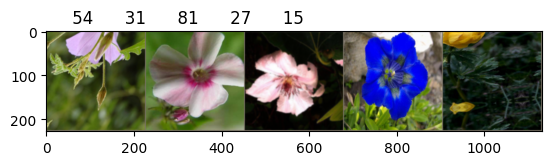

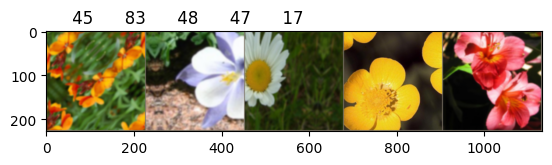

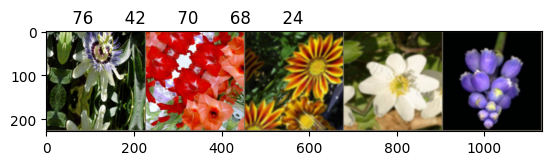

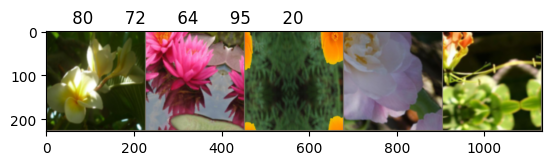

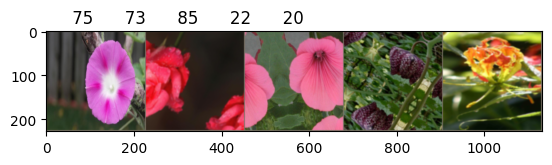

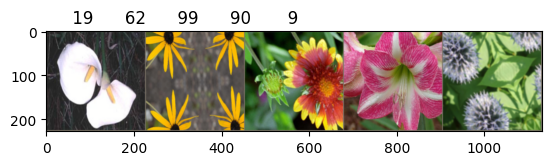

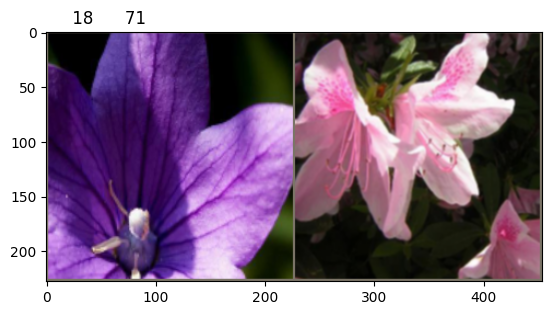

In [ ]:
tr_trans = [
              # alb.PadIfNeeded(40,40,cv2.BORDER_CONSTANT,[4,4],0),
              # alb.Rotate(limit=15, p=1.0),

              alb.Resize(height=256, width=256),


              alb.ShiftScaleRotate(shift_limit=0.4, scale_limit=0.5, rotate_limit=45, p=0.5),
              alb.GaussianBlur(blur_limit=(3, 7), p=0.5),
              alb.HorizontalFlip(p= 0.75),
              alb.GaussNoise(var_limit=(0.01, 0.1), p=0.5),
              alb.VerticalFlip(p=0.5),
              alb.CenterCrop(224,224, always_apply= True),
              # alb.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
              alb.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225]
              ),

              ToTensor()
              ]

trans = Flowers102_AlbumTrans(tr_trans)
data = FLOWER102DataLoader(trans, batch_size=32)
train_loader, test_loader = data.get_loaders()
display(train_loader, 32)

In [ ]:
model = model_custom_ResNET()
model = model.to(device)
model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

## One-Cycle Policy -- LR Finder

In [ ]:
wt_decay = 1e-3
mom = 0.9
lr_ = 1e-6
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_, nesterov=True, weight_decay=wt_decay, momentum = mom)
optimizer.scheduler = None
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.1, num_iter=10 * len(train_loader), step_mode="exp")

  0%|          | 0/320 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


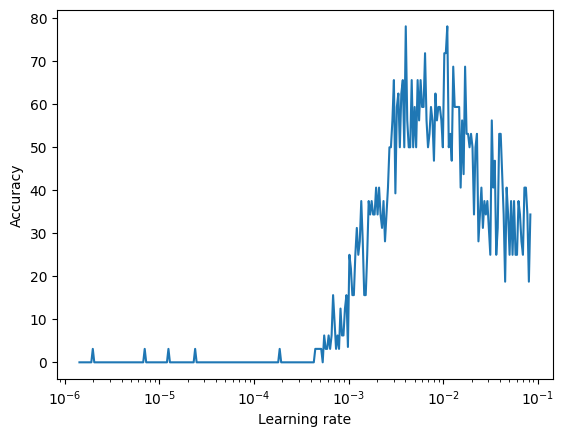

Best acc 78.125
Best LR:  0.004027315689175187


In [ ]:
lr_finder.plot(plot_case="acc")
best_lr = lr_finder.get_best_lr(case="acc")

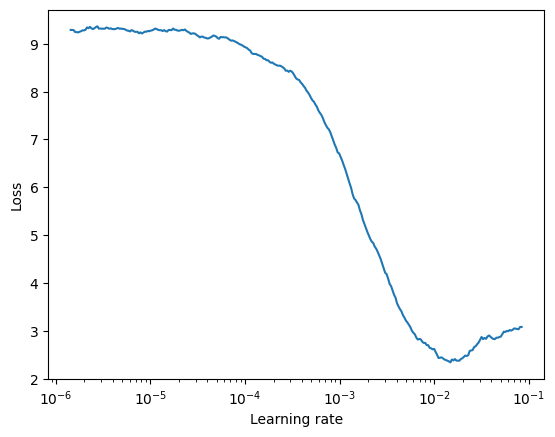

Best loss 2.3492448590907173
Best LR:  0.014766548524205685


In [ ]:
lr_finder.plot(plot_case="loss")
best_loss_lr = lr_finder.get_best_lr(case="loss")

In [ ]:
best_lr

0.004027315689175187

In [ ]:
lr_finder.reset()

In [ ]:
lr_list = []
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), best_lr, nesterov=True, weight_decay=wt_decay, momentum = mom)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                  max_lr=best_lr,
                  total_steps=24,
                  steps_per_epoch = len(train_loader),
                  epochs=24,
                  pct_start=5/24,
                  cycle_momentum=False,
                  div_factor=32,
                  final_div_factor=1,
                  anneal_strategy ='cos',
                  #annihilation_frac=0,
                  last_epoch=-1)
 # print('='*30 + f' div: {i} ' + '='*30)
epochs = 24
print('='*20 + 'START' + '='*20)
test = Test(model, device, test_loader)
train = Train(model, device, train_loader, optimizer, l1=0)
for epoch in range(epochs):
    print('='*20 + f' EPOCH: {epoch+1} ' + '='*20)
    train.train(epoch)
    lr_list.append(optimizer.param_groups[0]['lr'])
    print('\n Current LR:',lr_list[epoch])
    test.test()
    scheduler.step() #Have to give the val_loss or val_accuracy here. The metric on which we can to check
    #test.test()
  #fig, axs = plt.subplots(4,1,figsize=(15,10))
plt.plot(lr_list)


====================START====================
==================== EPOCH: 1 ====================


Loss=8.768357276916504 Batch_id=31 Accuracy=0.20: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


 Current LR: 0.00012585361528672477



Test set: Average loss: 0.2858, Accuracy: 3/1020 (0.29%)

==================== EPOCH: 2 ====================


Loss=5.690814018249512 Batch_id=31 Accuracy=2.84: 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


 Current LR: 0.0006972095077366247



Test set: Average loss: 0.1857, Accuracy: 106/1020 (10.39%)

==================== EPOCH: 3 ====================


Loss=3.5793328285217285 Batch_id=31 Accuracy=33.53: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


 Current LR: 0.0020765846522309557



Test set: Average loss: 0.0766, Accuracy: 565/1020 (55.39%)

==================== EPOCH: 4 ====================


Loss=2.244966983795166 Batch_id=31 Accuracy=66.37: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


 Current LR: 0.003455959796725287



Test set: Average loss: 0.0523, Accuracy: 675/1020 (66.18%)

==================== EPOCH: 5 ====================


Loss=1.3957048654556274 Batch_id=31 Accuracy=79.80: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


 Current LR: 0.004027315689175187



Test set: Average loss: 0.0486, Accuracy: 735/1020 (72.06%)

==================== EPOCH: 6 ====================


Loss=0.6801983118057251 Batch_id=31 Accuracy=89.51: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


 Current LR: 0.004000710260419411



Test set: Average loss: 0.0349, Accuracy: 815/1020 (79.90%)

==================== EPOCH: 7 ====================


Loss=0.14753016829490662 Batch_id=31 Accuracy=91.37: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


 Current LR: 0.003921619700893366



Test set: Average loss: 0.0301, Accuracy: 832/1020 (81.57%)

==================== EPOCH: 8 ====================


Loss=0.39867764711380005 Batch_id=31 Accuracy=93.63: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


 Current LR: 0.0037922013948872226



Test set: Average loss: 0.0254, Accuracy: 845/1020 (82.84%)

==================== EPOCH: 9 ====================


Loss=0.1224852129817009 Batch_id=31 Accuracy=95.49: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


 Current LR: 0.0036159855364204813



Test set: Average loss: 0.0246, Accuracy: 856/1020 (83.92%)

==================== EPOCH: 10 ====================


Loss=0.09639978408813477 Batch_id=31 Accuracy=96.57: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


 Current LR: 0.0033977788347516564



Test set: Average loss: 0.0213, Accuracy: 884/1020 (86.67%)

==================== EPOCH: 11 ====================


Loss=0.12555080652236938 Batch_id=31 Accuracy=96.47: 100%|██████████| 32/32 [00:10<00:00,  3.10it/s]


 Current LR: 0.0031435333998798554



Test set: Average loss: 0.0208, Accuracy: 880/1020 (86.27%)

==================== EPOCH: 12 ====================


Loss=0.10588941723108292 Batch_id=31 Accuracy=96.96: 100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


 Current LR: 0.002860184384499996



Test set: Average loss: 0.0194, Accuracy: 880/1020 (86.27%)

==================== EPOCH: 13 ====================


Loss=0.10225093364715576 Batch_id=31 Accuracy=97.75: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


 Current LR: 0.0025554608111158865



Test set: Average loss: 0.0174, Accuracy: 901/1020 (88.33%)

==================== EPOCH: 14 ====================


Loss=0.39216354489326477 Batch_id=31 Accuracy=97.84: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


 Current LR: 0.0022376747444543747



Test set: Average loss: 0.0174, Accuracy: 910/1020 (89.22%)

==================== EPOCH: 15 ====================


Loss=0.25168171525001526 Batch_id=31 Accuracy=98.63: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


 Current LR: 0.0019154945600075369



Test set: Average loss: 0.0161, Accuracy: 914/1020 (89.61%)

==================== EPOCH: 16 ====================


Loss=0.06729573756456375 Batch_id=31 Accuracy=99.02: 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


 Current LR: 0.0015977084933460248



Test set: Average loss: 0.0156, Accuracy: 912/1020 (89.41%)

==================== EPOCH: 17 ====================


Loss=0.06091655418276787 Batch_id=31 Accuracy=98.73: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


 Current LR: 0.0012929849199619155



Test set: Average loss: 0.0150, Accuracy: 924/1020 (90.59%)

==================== EPOCH: 18 ====================


Loss=0.018733860924839973 Batch_id=31 Accuracy=99.12: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


 Current LR: 0.0010096359045820569



Test set: Average loss: 0.0150, Accuracy: 923/1020 (90.49%)

==================== EPOCH: 19 ====================


Loss=0.2308228462934494 Batch_id=31 Accuracy=99.31: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


 Current LR: 0.0007553904697102556



Test set: Average loss: 0.0147, Accuracy: 925/1020 (90.69%)

==================== EPOCH: 20 ====================


Loss=0.0801730528473854 Batch_id=16 Accuracy=99.08:  53%|█████▎    | 17/32 [00:04<00:04,  3.43it/s]


KeyboardInterrupt: ignored

# Result Analysis

In [ ]:
import Packages.plot
from Packages.plot import mis, gen_cam, plot_pred_cam, plot_act_cam
import matplotlib.pyplot as plt

In [ ]:
import os

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Load Best Model

In [ ]:
best_model = models.resnet50().to(device)
best_model.load_state_dict(torch.load('/content/classifier.pt'))
best_model.eval()
print('Best Model Loaded!')

In [ ]:
from Packages.graphs import acc_loss, testvtrain, class_acc

In [ ]:
mis(best_model, device, test_loader, 25)

## GRADCAM

In [ ]:
layers = ['layer1', 'layer2', 'layer3',]
for layer in layers:
  gen_cam(best_model, layer) #GradCAM for Misclassified w.r.t Predicted Class
  gen_cam(best_model, layer, class_idx= Packages.plot.true_list) #GradCAM for Misclassified w.r.t Actual Class
  # gen_cam(best_model, layer, class_idx= true_list)

In [ ]:
plot_pred_cam(25, 3)

In [ ]:
plot_act_cam(25,3)

In [ ]:
acc_loss(train, test)

In [ ]:
testvtrain(train, test)

In [ ]:
class_acc(model, device, test_loader)

In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
len(lr_list)

In [ ]:
set_lr = set(lr_list)

In [ ]:
len(set_lr)

In [ ]:
set_lr

In [ ]:
plt.plot(lr_list)
plt.title('Change in Learning Rate')
plt.xlabel('epochs')
plt.ylabel('Learning Rate')